# Melanoma Detection Assignment
                                        ~by Kiran Dalmiya

### Problem statement: 

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

-Actinic keratosis

-Basal cell carcinoma

-Dermatofibroma

-Melanoma

-Nevus

-Pigmented benign keratosis

-Seborrheic keratosis

-Squamous cell carcinoma

-Vascular lesion

# Step 1 : Data Reading/Data Understanding

#### To do: Take necessary actions to read the data
### Importing Skin Cancer Data


### Importing all the important libraries

In [200]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Lambda,Dense,Flatten,Dropout,Activation,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.models import Model
from tensorflow.keras.models import Sequential

In [202]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [302]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r"C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path(r"C:\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

In [303]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

# Step 2 : Dataset Creation

### Create a dataset



In [304]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [305]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Ratio of training and testing(validation) data is 80-20%

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,         # Specify validation split ratio
    subset="training",            # Specify subset as "training"
    seed=123,                     # Use seed=123
    batch_size=32,                # Specify batch size
    image_size=(180, 180)         # Specify image size
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [306]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Use image_dataset_from_directory to create the validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,         # Specify validation split ratio
    subset="validation",          # Specify subset as "validation"
    seed=123,                     # Use seed=123
    batch_size=32,                # Specify batch size
    image_size=(180, 180)         # Specify image size
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [474]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

# Step 3 : Dataset visualisation
### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

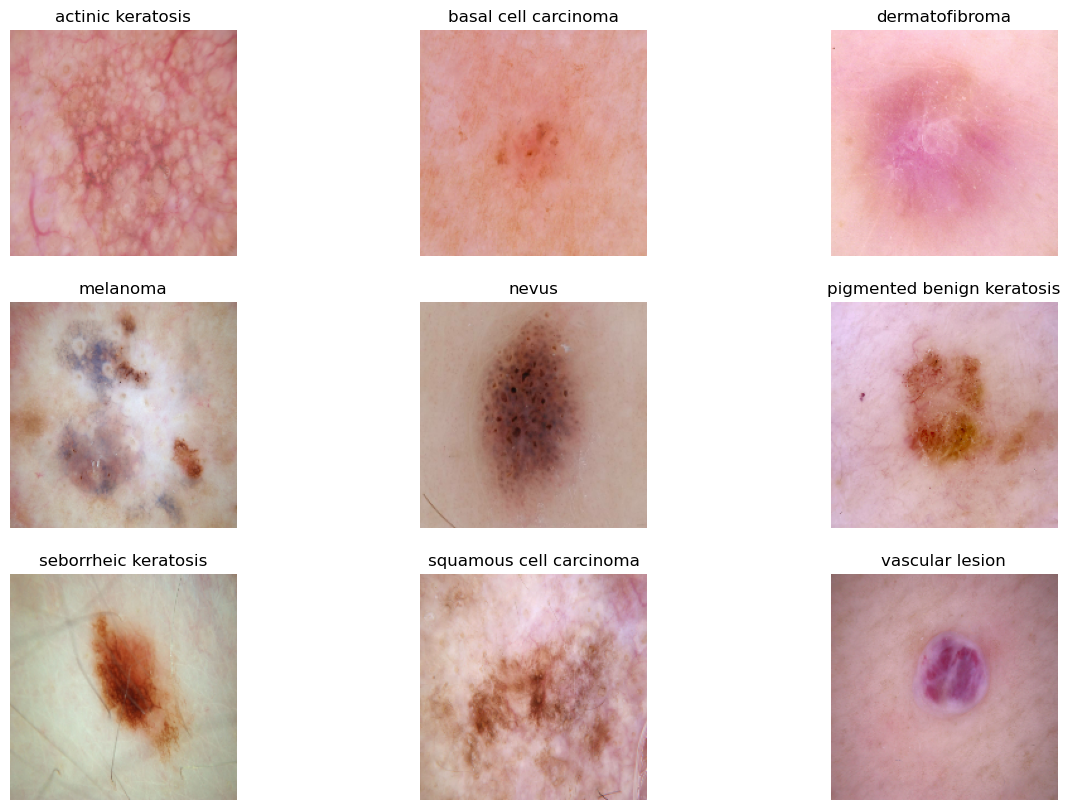

In [308]:
import matplotlib.pyplot as plt

# Iterate through the dataset to get one image from each class
num_classes = 9

plt.figure(figsize=(15, 10))
for i in range(num_classes):
    # Get one batch of images from the dataset
    for images, labels in train_ds:
        try:
            # Find the index of the class in the dataset
            class_index = labels.numpy().tolist().index(i)
            # Plot the first image of the class
            plt.subplot(3, 3, i+1)
            plt.imshow(images[class_index].numpy().astype("uint8"))
            plt.title(class_names[i])
            plt.axis("off")
            break  # Only one image per class
        except ValueError:
            continue  # If label i is not found, continue to the next batch
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`.

This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). 

The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

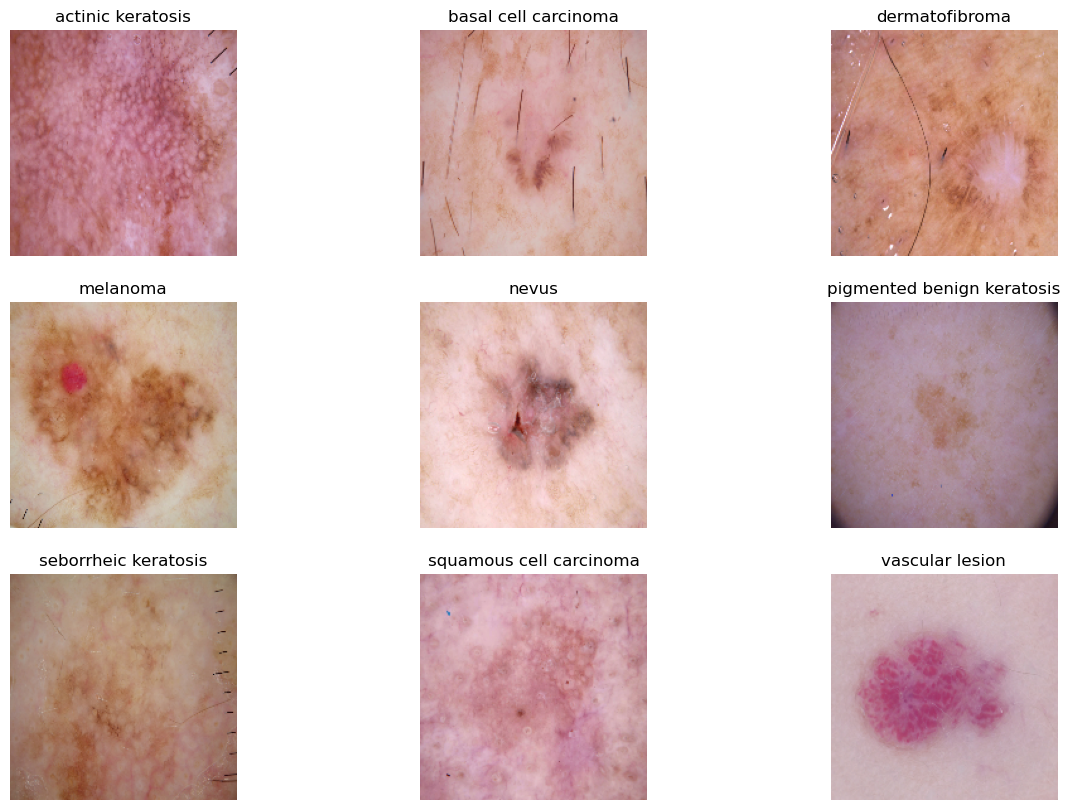

In [309]:
plt.figure(figsize=(15, 10))

# Iterate through the dataset to get one image from each class
for images, labels in train_ds.take(1):  # Take one batch from the dataset
    for i in range(len(class_names)):
        # Find the index of the first image of each class
        index = (labels.numpy() == i).argmax()
        # Plot the image
        plt.subplot(3, 3, i+1)
        plt.imshow(images[index].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

# Show the plot
plt.show()

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Step 4 : Model Building & training

### Create the model

* Creating a CNN model, which can accurately detect 9 classes present in the dataset.

* We will Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). 

* The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. 

* Here, it is good to standardize values to be in the `[0, 1]`

In [311]:
# SIMPLE VANILLA model building
#from tensorflow.keras.layers.preprocessing import Rescaling

from tensorflow.keras.layers import Rescaling

# Create a Sequential model
model = Sequential()

# Normalize pixel values to be in the [0, 1] range
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))


# Add convolutional layers
#First Convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Second Convolution layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Third Convolution layer
model.add(Conv2D(128,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a flattening layer
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))


model.add(Dense(num_classes, activation='softmax'))


In [312]:
### Todo, choose an appropirate optimiser and loss function

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [313]:
# View the summary of all layers
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_14 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [314]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    shuffle=True
    
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.2197 - loss: 2.1307 - val_accuracy: 0.4027 - val_loss: 1.8343
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.4268 - loss: 1.6201 - val_accuracy: 0.5011 - val_loss: 1.4839
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5029 - loss: 1.4415 - val_accuracy: 0.5123 - val_loss: 1.3933
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5208 - loss: 1.3551 - val_accuracy: 0.4966 - val_loss: 1.4645
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5252 - loss: 1.3218 - val_accuracy: 0.5190 - val_loss: 1.4500
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5690 - loss: 1.2794 - val_accuracy: 0.5414 - val_loss: 1.4185
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5759 - loss: 1.2072 - val_accuracy: 0.5391 - val_loss: 1.3760
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6078 - loss: 1.1308 - val_accuracy: 0.5347 - val_loss

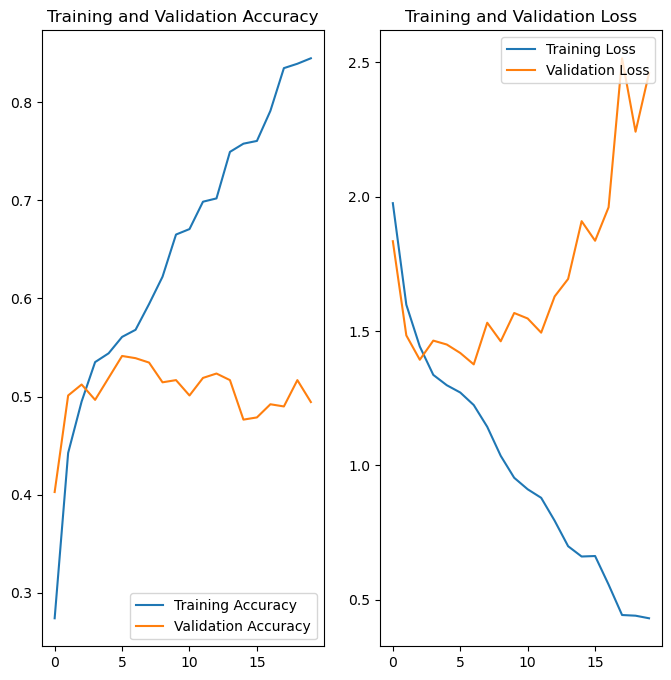

In [315]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()







### Findings 

The model shows evidence of overfitting:

- Training accuracy is higher (85%) than validation accuracy (49%).
- This indicates that this model overfits
- Validation loss (2.45) is substantially higher than training loss (0.41).
- Validation accuracy doesn't improve significantly over epochs.
- Further regularization techniques are needed to address overfitting.

In [316]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [317]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
# resize and rescale the value 
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_height,img_width),
    tf.keras.layers.Rescaling(1.0/255)
])



In [318]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# data augmentation

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.3)
])

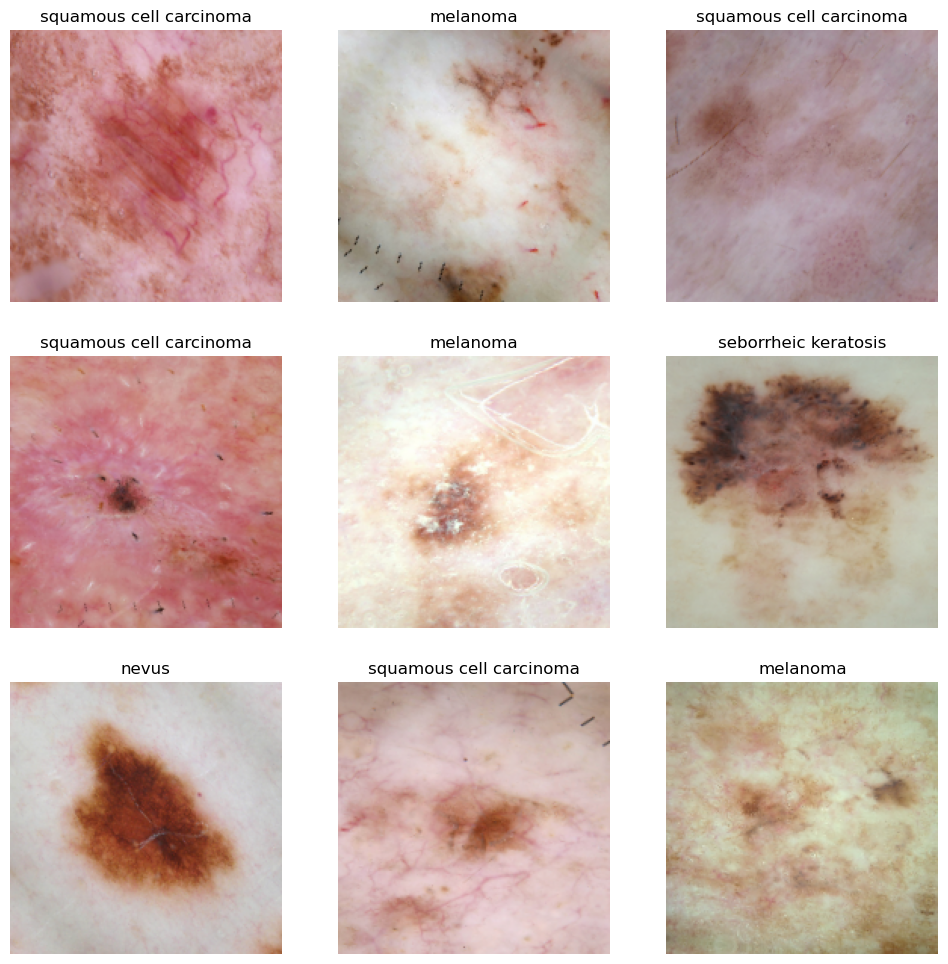

In [319]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [320]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Using Augmentation and drop out layer 

num_classes=9
model = Sequential([data_augmentation],layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))


# Add convolutional layers 1

model.add(Conv2D(32, kernel_size=(3, 3),padding='Same', activation='relu',input_shape=(180,180,32)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add convolutional layers 2
model.add(Conv2D(64, kernel_size=(3, 3),padding='Same', activation='relu',input_shape=(180,180,32)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add convolutional layers 3
model.add(Conv2D(128, kernel_size=(3, 3),padding='Same', activation='relu',input_shape=(180,180,32)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))                   

model.add(Dense(num_classes,activation='softmax'))

### Compiling the model


In [321]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [322]:
model.build((32, img_height, img_width, 3))

In [323]:
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_20 (Sequential)           │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (32, 180, 180, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (32, 90, 90, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (32, 90, 90, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (32, 45, 45, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (32, 45, 45, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (32, 22, 22, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (32, 22, 22, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (32, 61952)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (32, 128)                   │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (32, 9)                     │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [324]:
## Your code goes here, note: train your model for 20 epochs
 

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    shuffle=True
    
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.1926 - loss: 96.5585 - val_accuracy: 0.3893 - val_loss: 1.6934
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.3428 - loss: 1.7645 - val_accuracy: 0.3937 - val_loss: 1.7158
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.3651 - loss: 1.8298 - val_accuracy: 0.4251 - val_loss: 1.5794
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4005 - loss: 1.6848 - val_accuracy: 0.4609 - val_loss: 1.5252
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.4166 - loss: 1.6329 - val_accuracy: 0.3736 - val_loss: 1.6574
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.4455 - loss: 1.5738 - val_accuracy: 0.4653 - val_loss: 1.5412
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.4338 - loss: 1.6147 - val_accuracy: 0.4519 - val_loss: 1.6176
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.3520 - loss: 1.8361 - val_accuracy: 0.3982 - val_l

### Visualizing the results

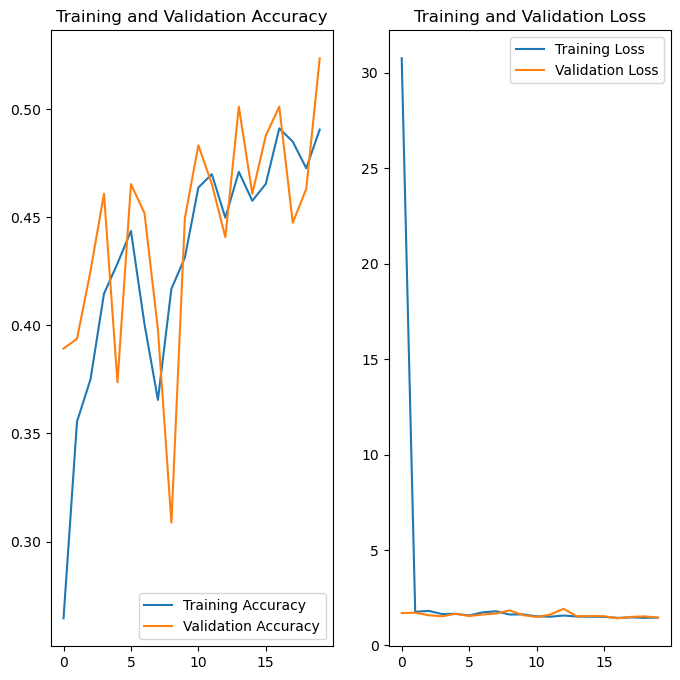

In [325]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Finding from Second Model

- Although there hasn't been improvement in accuracy(Its decresed actually), the implementation of data augmentation has effectively addressed the overfitting issue.

- Considering that the model hasn't been trained for a sufficient number of epochs, it's premature to draw any conclusions. Increasing the number of epochs might lead to improved accuracy.

In summary, while data augmentation has mitigated overfitting, further training could potentially enhance the model's accuracy.


#### **Todo:** Find the distribution of classes in the training dataset.


 **Context:** 
 Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [327]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [328]:
count=[]
for name in class_names:
        count.append(len(list(data_dir_train.glob(name+'/*.jpg'))))
count

[114, 376, 95, 438, 357, 462, 77, 181, 139]

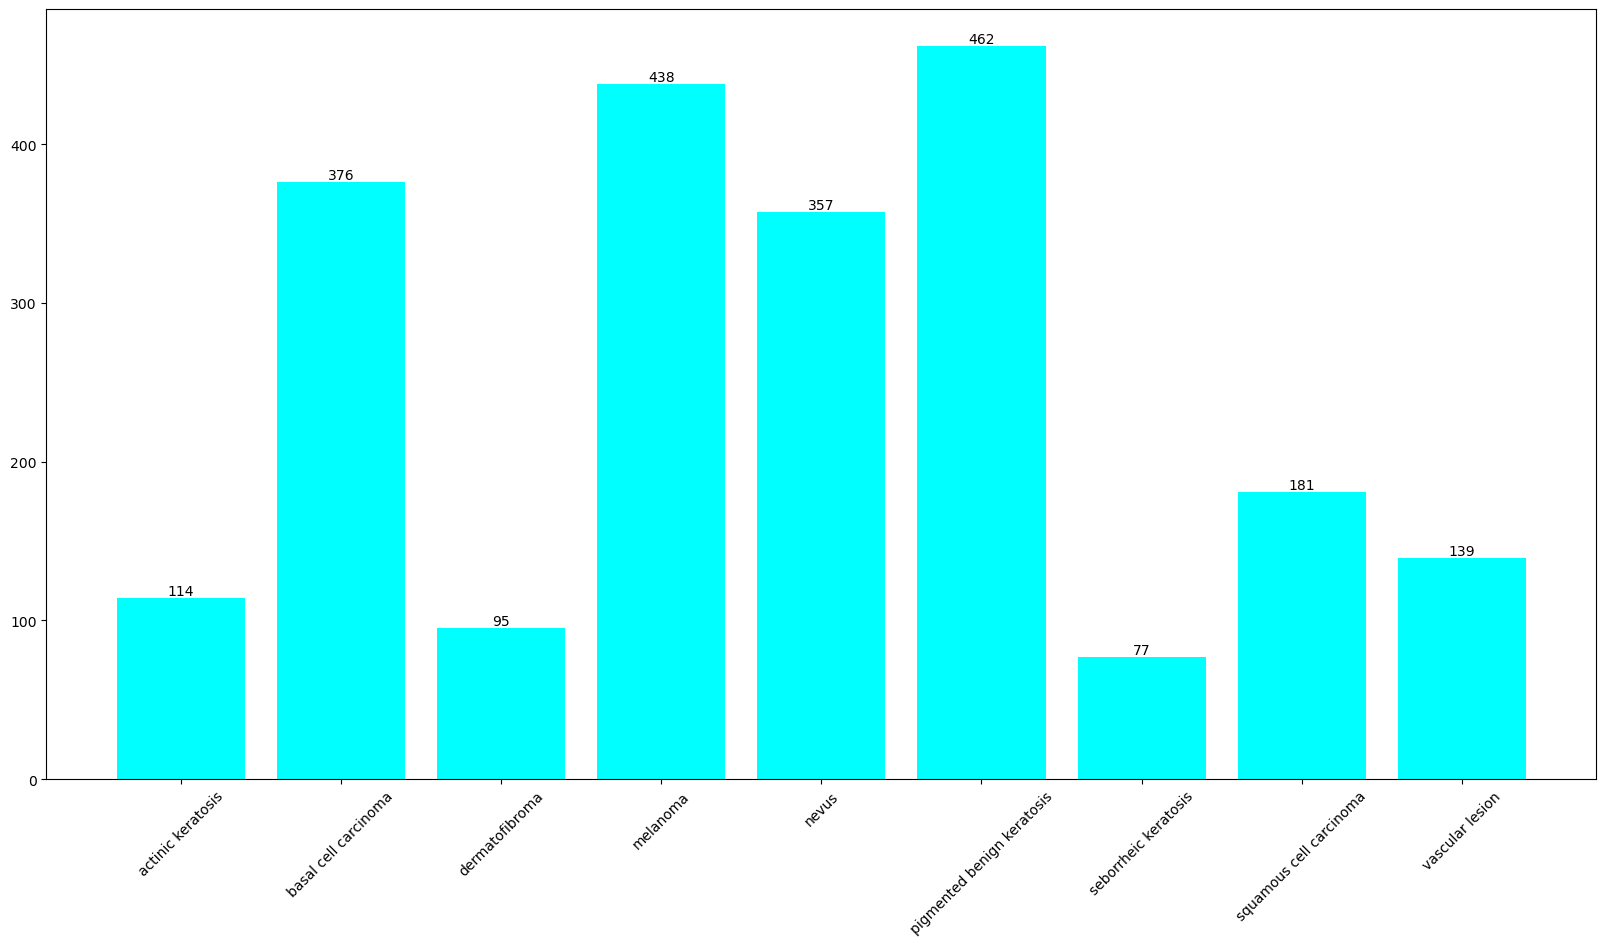

In [329]:
#plot number of images in each Class
count=[]
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'/*.jpg'))))

bars = plt.bar(class_names, count,color= 'cyan')

for bar, value in zip(bars, count):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), value, ha='center', va='bottom')


#plt.bar(class_names,count)

#### **Todo:** Write your findings here: 

### - Seborrheic keratosis class has the least number of samples i.e. 77 samples
### - Pigmented benign keratosis classes dominate the data in terms proportionate number of samples with 462 samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [269]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [297]:
pip show Augmentor


Name: Augmentor
Version: 0.2.12
Summary: Image augmentation library for Machine Learning
Home-page: https://github.com/mdbloice/Augmentor
Author: Marcus D. Bloice
Author-email: marcus.bloice@medunigraz.at
License: MIT
Location: C:\Users\dalmi\anaconda3\Lib\site-packages
Requires: numpy, Pillow, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [298]:
pip install Augmentor==0.2.8

  Obtaining dependency information for Augmentor==0.2.8 from https://files.pythonhosted.org/packages/cb/79/861f38d5830cff631e30e33b127076bfef8ac98171e51daa06df0118c75f/Augmentor-0.2.8-py2.py3-none-any.whl.metadata
  Attempting uninstall: Augmentor
    Found existing installation: Augmentor 0.2.12
    Uninstalling Augmentor-0.2.12:
      Successfully uninstalled Augmentor-0.2.12
Note: you may need to restart the kernel to use updated packages.


In [330]:
for class_name in class_names:
    class_dir = os.path.join(r"C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train", class_name)
    output_dir = os.path.join(class_dir, 'output')
    os.makedirs(output_dir, exist_ok=True)  # Create 'output' directory if it doesn't exist

    print(f"Augmenting images in class: {class_name}")
    print(f"Class directory: {class_dir}")
    print(f"Output directory: {output_dir}")

    p = Augmentor.Pipeline(class_dir, output_directory=output_dir, save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    
    try:
        p.sample(500)
    except Exception as e:
        print(f"Error encountered while augmenting images in class {class_name}: {e}")

Augmenting images in class: actinic keratosis
Class directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis
Output directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output
Initialised with 114 image(s) found.
Output directory set to C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1AB16977390>: 100%|█| 500/500 [00:19<00:


Augmenting images in class: basal cell carcinoma
Class directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma
Output directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output
Initialised with 376 image(s) found.
Output directory set to C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AC86546B90>: 100%|█| 500/500 [00:19<00:00, 25.01 Samples/


Augmenting images in class: dermatofibroma
Class directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma
Output directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output
Initialised with 95 image(s) found.
Output directory set to C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AB55F27A10>: 100%|█| 500/500 [00:18<00:00, 26.67 Samples/


Augmenting images in class: melanoma
Class directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma
Output directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output
Initialised with 438 image(s) found.
Output directory set to C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1AC86544710>: 100%|█| 500/500 [01:34<00:00,  5.27 Samples


Augmenting images in class: nevus
Class directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus
Output directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output
Initialised with 357 image(s) found.
Output directory set to C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1AB55F31890>: 100%|█| 500/500 [01:16<00:


Augmenting images in class: pigmented benign keratosis
Class directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis
Output directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output
Initialised with 462 image(s) found.
Output directory set to C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AB166A1110>: 100%|█| 500/500 [00:20<00:00, 24.47 Samples/


Augmenting images in class: seborrheic keratosis
Class directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis
Output directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output
Initialised with 77 image(s) found.
Output directory set to C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1AB51D1F5D0>: 100%|█| 500/500 [00:46<00:00, 10.86 Samples


Augmenting images in class: squamous cell carcinoma
Class directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma
Output directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output
Initialised with 181 image(s) found.
Output directory set to C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1AC62E00F10>: 100%|█| 500/500 [00:19<00:


Augmenting images in class: vascular lesion
Class directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion
Output directory: C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output
Initialised with 139 image(s) found.
Output directory set to C:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AC5A7B6050>: 100%|█| 500/500 [00:19<00:00, 25.01 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [331]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

<BarContainer object of 9 artists>

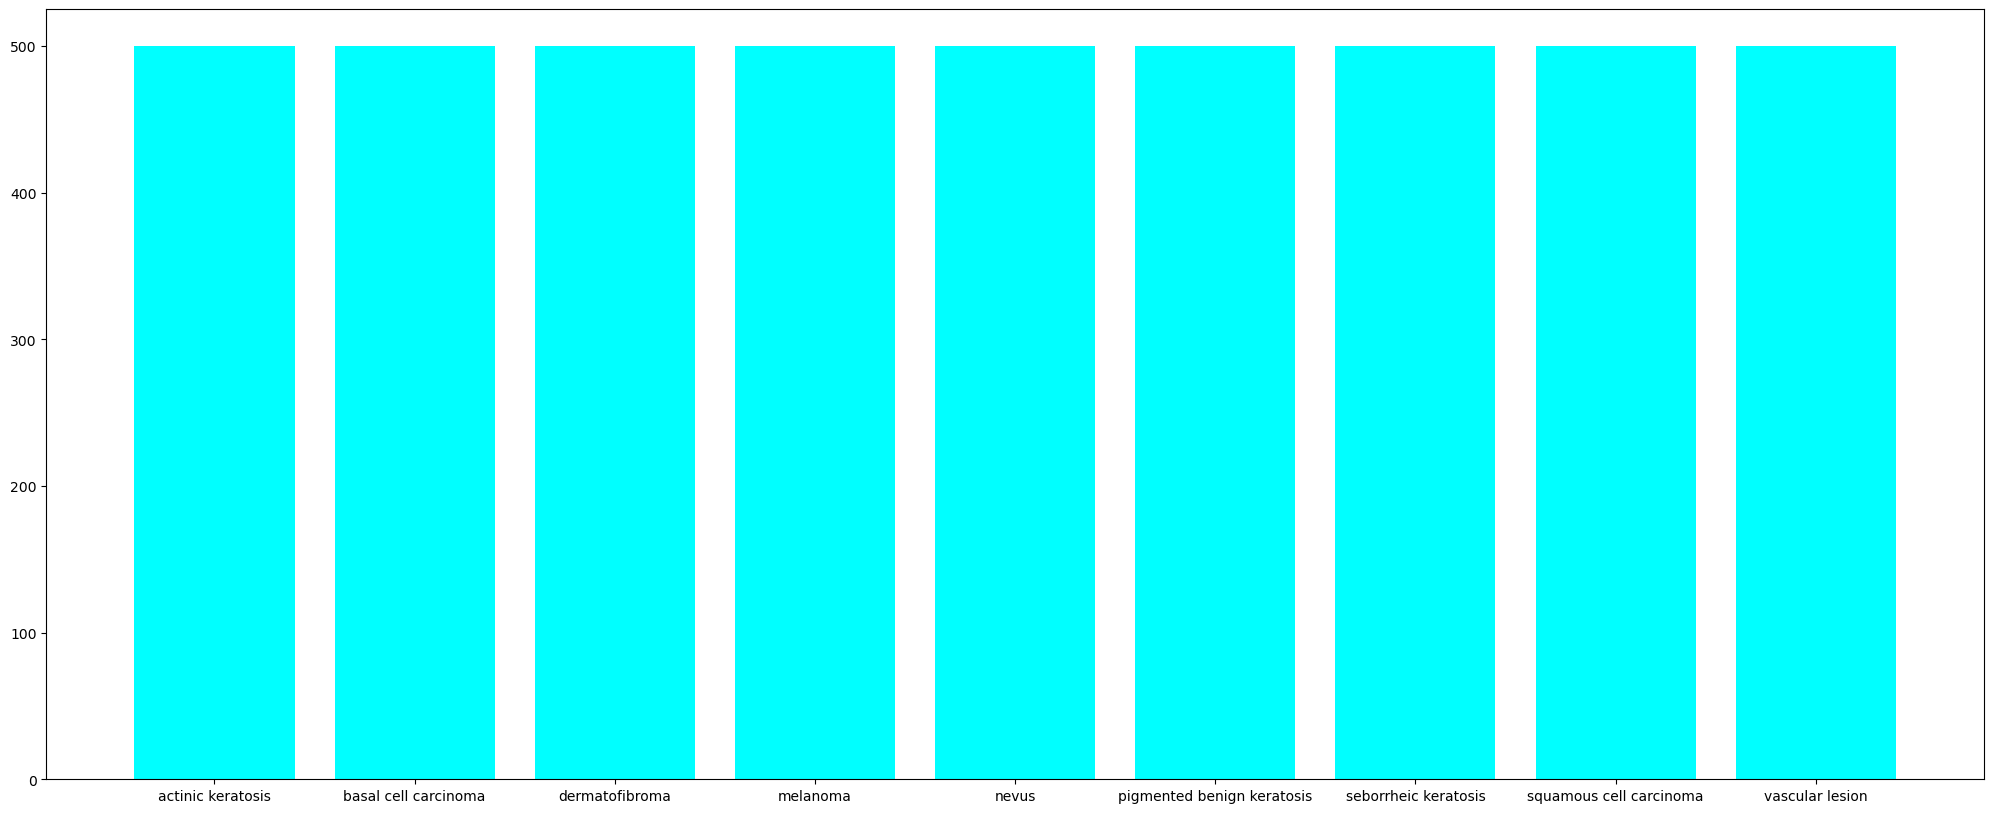

In [340]:
# Check the distribution of data again. 
count=[]
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'*/output/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count,color="cyan")

In [332]:
import os
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1feb0909-d3a0-41a3-a0a0-335e1dc3d923.jpg',
 'C:\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_cae63f41-ff55-4c27-ae9a-fdd4c71349b5.jpg',
 'C:\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_1b56baaa-3701-4777-8e08-8e59c69a8d20.jpg',
 'C:\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_525bdb63-420e-4b21-8267-e8dc122a4ec5.jpg',
 'C:\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_d1577f84-1e70-4d88-811f-278780f9a926.jpg',
 'C:\\Skin cancer ISIC The International Skin Imag

In [334]:
melanoma_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
melanoma_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [336]:
dataframe_dict_new = dict(zip(path_list, melanoma_list_new)) # changed path_list_new to path_list

In [341]:
# Get Existing images in Dataframe
path_list=[]
melanoma_list=[]
for name in class_names:
  for file in data_dir_train.glob(name+'/*.jpg'):
    path_list.append(str(file))
    melanoma_list.append(name)

dataframe_dict_original=dict(zip(path_list,melanoma_list))
original_df=pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])

In [343]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = pd.concat([original_df, df2], ignore_index=True)

In [344]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

Now, with 500 images added to each class, we've aimed to achieve a more balanced representation across all classes. Additional images can be incorporated as needed to further enhance the training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [351]:
import tensorflow as tf
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [354]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',    ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model 

In [468]:
## your code goes here

## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


num_classes=9

# Create a Sequential model
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
# Add convolutional layers 1

model.add(Conv2D(32, kernel_size=(3, 3),padding='Same', activation='relu',input_shape=(180,180,32)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add convolutional layers 2
model.add(Conv2D(64, kernel_size=(3, 3),padding='Same', activation='relu',input_shape=(180,180,32)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add convolutional layers 3
model.add(Conv2D(128, kernel_size=(3, 3),padding='Same', activation='relu',input_shape=(180,180,32)))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))                   

model.add(Dense(num_classes,activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [469]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [470]:
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_19 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [471]:
epochs = 30
## Your code goes here, use 50 epochs.

history = model.fit(     # your model fit code
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.2288 - loss: 2.0227 - val_accuracy: 0.3935 - val_loss: 1.6074
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.4195 - loss: 1.5334 - val_accuracy: 0.4826 - val_loss: 1.3884
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.4966 - loss: 1.3534 - val_accuracy: 0.5457 - val_loss: 1.2100
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.5567 - loss: 1.1949 - val_accuracy: 0.5969 - val_loss: 1.1106
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.6106 - loss: 1.0504 - val_accuracy: 0.6140 - val_loss: 1.0493
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.6660 - loss: 0.9038 - val_accuracy: 0.6934 - val_loss: 0.9056
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7052 - loss: 0.8140 - val_accuracy: 0.6964 - val_loss: 0.8693
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7469 - loss: 0.6986 - val_accu

#### **Todo:**  Visualize the model results

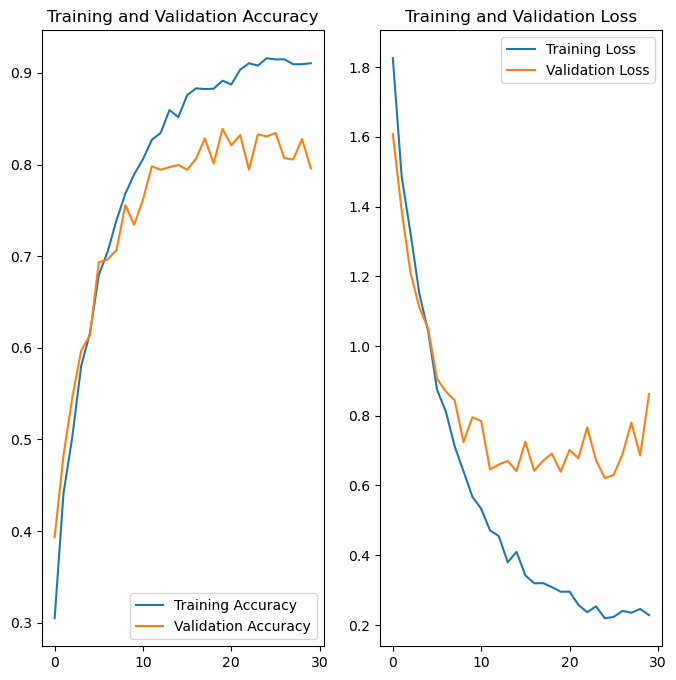

In [475]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



-Accuracy on training data has increased by using Augmentor library

-Model is still overfitting

-The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

-The Model can be further improved by tuning the hyperparameter

### Creating Final model

In [481]:
## your code goes here

## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


num_classes=9

# Create a Sequential model
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# Add convolutional layers 1
model.add(Conv2D(32, kernel_size=(3, 3),padding='Same', activation='relu',input_shape=(180,180,32)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add convolutional layers 2
model.add(Conv2D(64, kernel_size=(3, 3),padding='Same', activation='relu',input_shape=(180,180,32)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add convolutional layers 3
model.add(Conv2D(128, kernel_size=(3, 3),padding='Same', activation='relu',input_shape=(180,180,32)))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Dropout layer with 20% Fraction of the input units to drop.
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))                   

model.add(Dense(num_classes,activation='softmax'))

In [482]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [483]:
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_21 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [484]:
epochs = 30
## Your code goes here, use 50 epochs.

history = model.fit(     # your model fit code
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.2126 - loss: 2.1115 - val_accuracy: 0.3519 - val_loss: 1.6935
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.4080 - loss: 1.5789 - val_accuracy: 0.4766 - val_loss: 1.3550
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.4748 - loss: 1.3781 - val_accuracy: 0.5390 - val_loss: 1.1985
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.5635 - loss: 1.1847 - val_accuracy: 0.6058 - val_loss: 1.1023
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.6021 - loss: 1.0941 - val_accuracy: 0.6385 - val_loss: 0.9830
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.6305 - loss: 0.9862 - val_accuracy: 0.6385 - val_loss: 0.9898
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.6879 - loss: 0.8523 - val_accuracy: 0.6919 - val_loss: 0.8502
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.7188 - loss: 0.7877 - val_accu

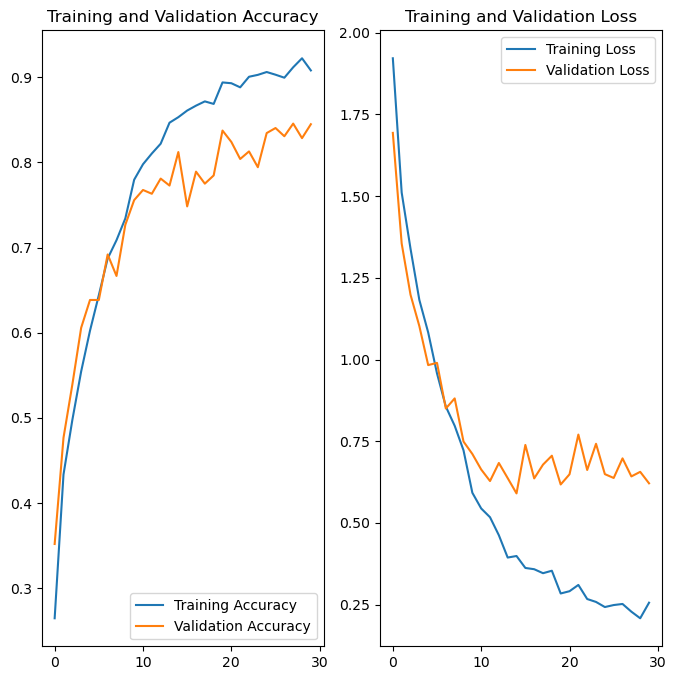

In [486]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings:

### A training accuracy of 89% and a validation accuracy of 84% suggest that the model is performing reasonably well.

# Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


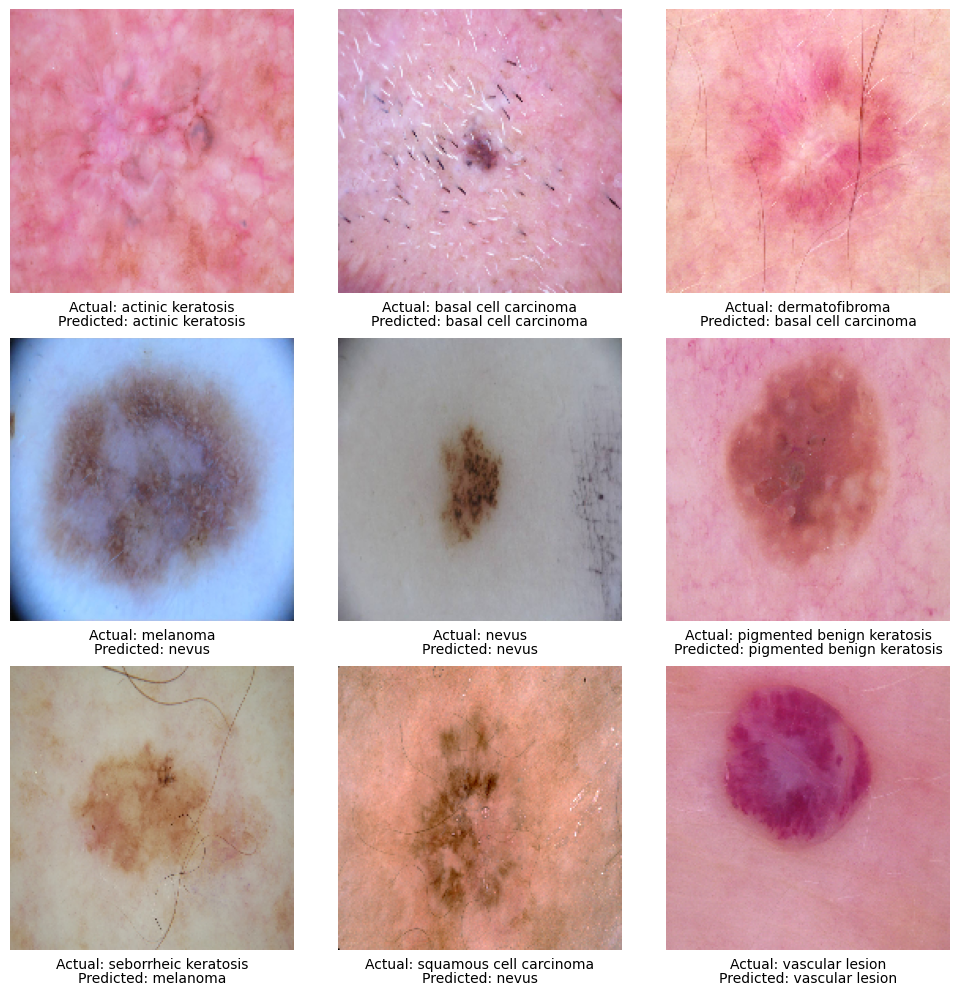

In [519]:
import os
import random
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

class_names = ['actinic keratosis','basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis',
               'seborrheic keratosis','squamous cell carcinoma','vascular lesion']

# Create a figure and axis objects for subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, class_name in enumerate(class_names):
    # Construct the path to the test images for the current class
    test_image_path = os.path.join(data_dir_test, class_name, '*.jpg')
    
    # Get the list of image paths for the current class
    class_image_paths = glob(test_image_path)
    
    # Select one image randomly from the list
    random_image_path = random.choice(class_image_paths)
    
    # Load the randomly selected test image
    Test_image = load_img(random_image_path, target_size=(180, 180, 3))

    # Display the image in the subplot
    row = i // 3  # Calculate row index
    col = i % 3   # Calculate column index
    axes[row, col].imshow(Test_image)
    #axes[row, col].set_title(class_name)
    axes[row, col].axis('off')

    # Prepare the image for prediction
    img = np.expand_dims(Test_image, axis=0)
    # Predict the class of the test image
    pred = model.predict(img)
    pred_class_index = np.argmax(pred)
    pred_class = class_names[pred_class_index]

    # Display actual and predicted classes as text below the image
    axes[row, col].text(0.5, -0.05, f"Actual: {class_name}", transform=axes[row, col].transAxes,
                        ha='center', va='center', fontsize=10, color='black')
    axes[row, col].text(0.5, -0.1, f"Predicted: {pred_class}", transform=axes[row, col].transAxes,
                        ha='center', va='center', fontsize=10, color='black')

    
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.grid(True)  
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4
Actual Class nevus
Predictive Class nevus


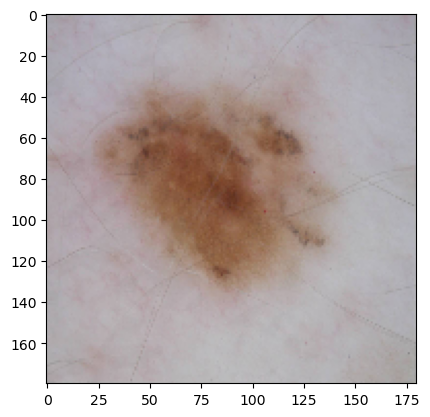

In [502]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[4], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
print(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[4] +'\n'+ "Predictive Class "+pred_class )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2
Actual Class dermatofibroma
Predictive Class dermatofibroma


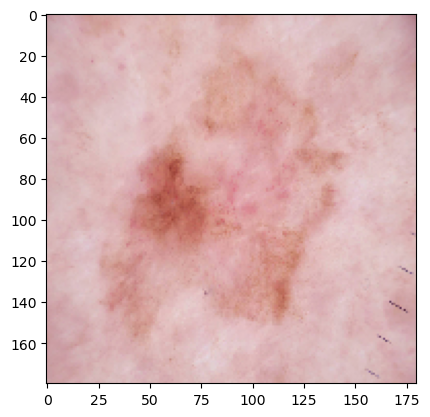

In [516]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[7], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
print(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[7] +'\n'+ "Predictive Class "+pred_class )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8
Actual Class vascular lesion
Predictive Class vascular lesion


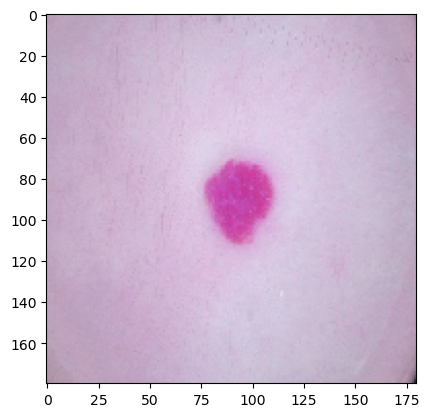

In [505]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[8], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
print(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[8] +'\n'+ "Predictive Class "+pred_class )